In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization
import cv2
import mediapipe as mp
import os
import numpy as np
from IPython.display import clear_output
import time
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.regularizers import l2

In [10]:
gesture_labels = {
    0: 'ain', 1: 'aleff', 2: 'bb', 3: 'dal', 4: 'dha', 5: 'dhad', 6: 'fa', 7: 'gaaf', 
    8: 'ghain', 9: 'ha', 10: 'haa', 11: 'jeem', 12: 'kaaf', 13: 'khaa', 14: 'laam', 
    15: 'meem', 16: 'nun', 17: 'ra', 18: 'saad', 19: 'seen', 20: 'sheen', 21: 'ta', 
    22: 'taa', 23: 'thaa', 24: 'thal', 25: 'waw', 26: 'yaa', 27: 'zay'
}
ARABIC_LETTERS_MAP = {
    0: ("ع", "Ayn"),        # matches 'ain' in gesture_labels
    1: ("ا", "alif"),       # matches 'aleff' in gesture_labels
    2: ("ب", "baa"),        # matches 'bb' in gesture_labels
    3: ("د", "daal"),       # matches 'dal' in gesture_labels
    4: ("ض", "Daad"),       # matches 'dha' in gesture_labels
    5: ("ذ", "thal"),       # matches 'dhad' in gesture_labels
    6: ("ف", "faa"),        # matches 'fa' in gesture_labels
    7: ("ق", "qaaf"),       # matches 'gaaf' in gesture_labels
    8: ("غ", "ghayn"),      # matches 'ghain' in gesture_labels
    9: ("ه", "haaw"),       # matches 'ha' in gesture_labels
    10: ("ح", "Haa"),       # matches 'haa' in gesture_labels
    11: ("ج", "Jiim"),      # matches 'jeem' in gesture_labels
    12: ("ك", "kaaf"),      # matches 'kaaf' in gesture_labels
    13: ("خ", "kha"),       # matches 'khaa' in gesture_labels
    14: ("ل", "laam"),      # matches 'laam' in gesture_labels
    15: ("م", "miim"),      # matches 'meem' in gesture_labels
    16: ("ن", "noon"),      # matches 'nun' in gesture_labels
    17: ("ر", "raa"),       # matches 'ra' in gesture_labels
    18: ("ص", "Saad"),      # matches 'saad' in gesture_labels
    19: ("س", "siin"),      # matches 'seen' in gesture_labels
    20: ("ش", "shiin"),     # matches 'sheen' in gesture_labels
    21: ("ت", "ta"),        # matches 'ta' in gesture_labels
    22: ("ط", "Taa"),       # matches 'taa' in gesture_labels
    23: ("ث", "tha"),       # matches 'thaa' in gesture_labels
    24: ("ذ", "thal"),      # matches 'thal' in gesture_labels
    25: ("و", "waaw"),      # matches 'waw' in gesture_labels
    26: ("ي", "yaa"),       # matches 'yaa' in gesture_labels
    27: ("ز", "zay"),       # matches 'zay' in gesture_labels
}

DATA_DIR = "/home/mercy/Jupyter-Work/Final Year Project/train_landmarks"  # Path to your extracted landmark .npy files
TEST_SIZE = 0.2 

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 1. Load and prepare CSV data (63 landmarks)
df = pd.read_csv("/home/mercy/Jupyter-Work/Final Year Project/train_landmarks/hand_landmarks3.csv")
X_csv = df.iloc[:, :-1].values  # Shape: (N, 63)
y_csv = df.iloc[:, -1].values   # Shape: (N,)

# Encode CSV labels (using gesture_labels mapping)
label_encoder = LabelEncoder()
y_csv = label_encoder.fit_transform(y_csv)  # Now 0-27 matching gesture_labels

# 2. Load and prepare NPY data (99 landmarks)
X_npy = []
y_npy = []

# Create mapping from ARABIC_LETTERS_MAP to gesture_labels indices
arabic_to_gesture_idx = {
    32: 1,   # alif -> aleff (1)
    33: 2,   # baa -> bb (2)
    34: 21,  # ta -> ta (21)
    35: 23,  # tha -> thaa (23)
    36: 11,  # Jiim -> jeem (11)
    37: 10,  # Haa -> haa (10)
    38: 13,  # kha -> khaa (13)
    39: 3,   # daal -> dal (3)
    40: 24,  # thal -> thal (24)
    41: 17,  # raa -> ra (17)
    42: 27,  # zay -> zay (27)
    43: 19,  # siin -> seen (19)
    44: 20,  # shiin -> sheen (20)
    45: 18,  # Saad -> saad (18)
    46: 4,   # Daad -> dha (4)
    47: 22,  # Taa -> taa (22)
    48: 23,  # Zaa -> thaa (23) [Note: conflict]
    49: 0,   # Ayn -> ain (0)
    50: 8,   # ghayn -> ghain (8)
    51: 6,   # faa -> fa (6)
    52: 7,   # qaaf -> gaaf (7)
    53: 12,  # kaaf -> kaaf (12)
    54: 14,  # laam -> laam (14)
    55: 15,  # miim -> meem (15)
    56: 16,  # noon -> nun (16)
    57: 9,   # haaw -> ha (9)
    58: 25,  # waaw -> waw (25)
    59: 26   # yaa -> yaa (26)
}

for label_folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, label_folder)
    if not os.path.isdir(folder_path):
        continue

    try:
        numeric_label = int(label_folder)
        if numeric_label not in arabic_to_gesture_idx:
            continue  # Skip unmapped labels

        for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(folder_path, file_name)
                sample = np.load(file_path)
                
                sample.shape == (63,)
                X_npy.append(sample)  # Use as-is
                y_npy.append(arabic_to_gesture_idx[numeric_label])

    except ValueError:
        continue

X_npy = np.array(X_npy, dtype=np.float32)  # Shape: (M, 63)
y_npy = np.array(y_npy, dtype=np.int32)    # Shape: (M,)

# 3. Combine datasets
X_combined = np.concatenate([X_csv, X_npy], axis=0)
y_combined = np.concatenate([y_csv, y_npy], axis=0)

# 4. Shuffle and split
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_combined,
    test_size=0.2,
    stratify=y_combined,
    random_state=42
)

# 5. Reshape for CNN
X_train = X_train.reshape(-1, 63, 1)
X_test = X_test.reshape(-1, 63, 1)

print("Final shapes:")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test: X={X_test.shape}, y={y_test.shape}")

Final shapes:
Train: X=(17580, 63, 1), y=(17580,)
Test: X=(4396, 63, 1), y=(4396,)


In [24]:
def create_1d_cnn(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.0001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Second Convolutional Block
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Third Convolutional Block
        Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Fully Connected Layers
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
        Dense(28, activation='softmax')
    ])
    
    return model

In [28]:
input_shape = (63, 1)  # 63 landmarks × 1 channel (static gesture)
num_classes = len(np.unique(y_train))


In [29]:
model = create_1d_cnn(input_shape, num_classes)

/home/mercy/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752160273.902069     509 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [30]:
optimizer = AdamW(learning_rate=0.0005, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 59, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,404 (1.18 MB)

 Trainable params: 308,508 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

In [34]:
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[ early_stopping, reduce_lr]
)


Epoch 1/100


I0000 00:00:1752160287.375143   30430 service.cc:152] XLA service 0x704950005b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752160287.375313   30430 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-07-10 20:11:27.513552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752160288.045550   30430 cuda_dnn.cc:529] Loaded cuDNN version 90501


 25/440 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1024 - loss: 3.5847

I0000 00:00:1752160293.489495   30430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


440/440 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.4805 - loss: 1.8223 - val_accuracy: 0.5660 - val_loss: 1.5032 - learning_rate: 5.0000e-04
Epoch 2/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8737 - loss: 0.4648 - val_accuracy: 0.8845 - val_loss: 0.4444 - learning_rate: 5.0000e-04
Epoch 3/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9239 - loss: 0.3085 - val_accuracy: 0.9002 - val_loss: 0.3914 - learning_rate: 5.0000e-04
Epoch 4/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9339 - loss: 0.2601 - val_accuracy: 0.9258 - val_loss: 0.3102 - learning_rate: 5.0000e-04
Epoch 5/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9538 - loss: 0.2085 - val_accuracy: 0.9374 - val_loss: 0.2876 - learning_rate: 5.0000e-04
Epoch 6/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9606 - loss: 0.1806 - val_accuracy: 0.9283 - val_loss: 0.3121 - learning_rate: 5.0000e-04
Epoch 7/100
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f} {test_loss}")


Test Accuracy: 0.9684 0.17176386713981628


In [16]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Predict labels for test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = y_test  # Use directly if y_test is already a 1D array of class labels

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9726 - loss: 0.1543 
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   


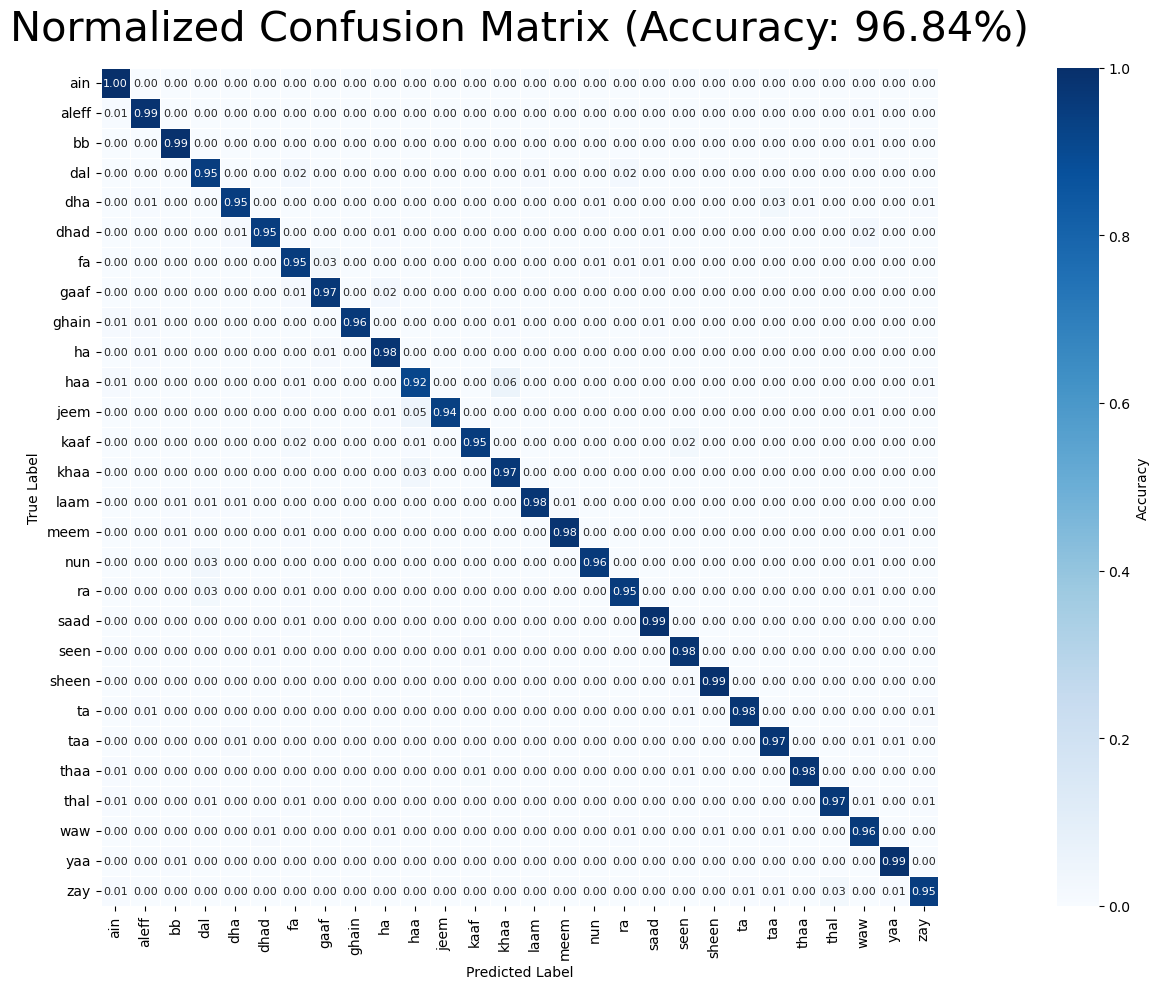

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your gesture labels
gesture_labels = {
    0: 'ain', 1: 'aleff', 2: 'bb', 3: 'dal', 4: 'dha', 5: 'dhad', 6: 'fa', 7: 'gaaf', 
    8: 'ghain', 9: 'ha', 10: 'haa', 11: 'jeem', 12: 'kaaf', 13: 'khaa', 14: 'laam', 
    15: 'meem', 16: 'nun', 17: 'ra', 18: 'saad', 19: 'seen', 20: 'sheen', 21: 'ta', 
    22: 'taa', 23: 'thaa', 24: 'thal', 25: 'waw', 26: 'yaa', 27: 'zay'
}

# Convert to class names
class_names = [gesture_labels[i] for i in sorted(gesture_labels.keys())]

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')  # Normalized by true labels

plt.figure(figsize=(24, 10))  # Large figure for 28 classes

# Create heatmap with seaborn
ax = sns.heatmap(cm, 
                 annot=True, 
                 fmt='.2f', 
                 cmap='Blues',
                 cbar_kws={'label': 'Accuracy'},
                 square=True,
                 linewidths=0.5,
                 annot_kws={'size': 8})

# Customize appearance
ax.set_xticklabels(class_names, rotation=90, fontsize=10)
ax.set_yticklabels(class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.title(f'Normalized Confusion Matrix (Accuracy: {test_accuracy:.2%})', fontsize=30, pad=20)


plt.tight_layout()
plt.savefig('confusion_matrix_heatmap.png', dpi=500, bbox_inches='tight')
plt.show()

In [19]:

# Print classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

         ain       0.95      1.00      0.97       153
       aleff       0.97      0.99      0.98       163
          bb       0.98      0.99      0.99       166
         dal       0.93      0.95      0.94       148
         dha       0.97      0.95      0.96       155
        dhad       0.98      0.95      0.96       136
          fa       0.92      0.95      0.94       160
        gaaf       0.96      0.97      0.96       147
       ghain       1.00      0.96      0.98       157
          ha       0.96      0.98      0.97       149
         haa       0.91      0.92      0.91       142
        jeem       1.00      0.94      0.97       150
        kaaf       0.97      0.95      0.96       164
        khaa       0.94      0.97      0.95       148
        laam       0.99      0.98      0.98       162
        meem       0.99      0.98      0.99       160
         nun       0.99      0.96      0.97       151
   

In [39]:
model.save("AlphabetModel.keras")

In [7]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('AlphabetModel.keras') 

In [6]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# Gesture labels mapping
gesture_labels = {
    0: ("ع", "Ayn"),        # matches 'ain' in gesture_labels
    1: ("ا", "alif"),       # matches 'aleff' in gesture_labels
    2: ("ب", "baa"),        # matches 'bb' in gesture_labels
    3: ("د", "daal"),       # matches 'dal' in gesture_labels
    4: ("ض", "Daad"),       # matches 'dha' in gesture_labels
    5: ("ذ", "thal"),       # matches 'dhad' in gesture_labels
    6: ("ف", "faa"),        # matches 'fa' in gesture_labels
    7: ("ق", "qaaf"),       # matches 'gaaf' in gesture_labels
    8: ("غ", "ghayn"),      # matches 'ghain' in gesture_labels
    9: ("ه", "haaw"),       # matches 'ha' in gesture_labels
    10: ("ح", "Haa"),       # matches 'haa' in gesture_labels
    11: ("ج", "Jiim"),      # matches 'jeem' in gesture_labels
    12: ("ك", "kaaf"),      # matches 'kaaf' in gesture_labels
    13: ("خ", "kha"),       # matches 'khaa' in gesture_labels
    14: ("ل", "laam"),      # matches 'laam' in gesture_labels
    15: ("م", "miim"),      # matches 'meem' in gesture_labels
    16: ("ن", "noon"),      # matches 'nun' in gesture_labels
    17: ("ر", "raa"),       # matches 'ra' in gesture_labels
    18: ("ص", "Saad"),      # matches 'saad' in gesture_labels
    19: ("س", "siin"),      # matches 'seen' in gesture_labels
    20: ("ش", "shiin"),     # matches 'sheen' in gesture_labels
    21: ("ت", "ta"),        # matches 'ta' in gesture_labels
    22: ("ط", "Taa"),       # matches 'taa' in gesture_labels
    23: ("ث", "tha"),       # matches 'thaa' in gesture_labels
    24: ("ذ", "thal"),      # matches 'thal' in gesture_labels
    25: ("و", "waaw"),      # matches 'waw' in gesture_labels
    26: ("ي", "yaa"),       # matches 'yaa' in gesture_labels
    27: ("ز", "zay"),       # matches 'zay' in gesture_labels
}

# IP Camera setup (replace with your camera URL)
ip_camera_url = "http://192.168.100.141:8080/video"  # e.g., "http://192.168.1.100:8080/video"
cap = cv2.VideoCapture(ip_camera_url)

# Set desired resolution (adjust based on your camera capabilities)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# ROI (Region of Interest) parameters
roi_size = 300  # Size of the square ROI
roi_x = 100     # X position of ROI
roi_y = 100     # Y position of ROI

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    
    # Flip frame horizontally for mirror effect
    frame = cv2.flip(frame, 1)
    
    # Get ROI for processing
    roi = frame[roi_y:roi_y+roi_size, roi_x:roi_x+roi_size]
    
    # Convert ROI to RGB for MediaPipe
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    
    # Process with MediaPipe
    results = hands.process(roi_rgb)
    
    # Draw ROI rectangle
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x+roi_size, roi_y+roi_size), (0, 255, 0), 2)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks
            mp.solutions.drawing_utils.draw_landmarks(
                frame[roi_y:roi_y+roi_size, roi_x:roi_x+roi_size],
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS)
            
            # Extract landmarks and normalize
            landmarks = []
            for landmark in hand_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z])
            
            landmarks = np.array(landmarks[:63])  # Take first 63 values (21 landmarks)
            landmarks = landmarks.reshape(1, 63, 1)  # Reshape for model
            
            # Predict gesture
            prediction = model.predict(landmarks)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            
            # Display prediction
            if confidence > 0.7:  # Confidence threshold
                gesture = gesture_labels[predicted_class][1]
                cv2.putText(frame, f"{gesture} ({confidence:.2f})", 
                            (roi_x, roi_y-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display instructions
    cv2.putText(frame, "Put your hand in the green box", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "Press 'q' to quit", (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Show frame
    cv2.imshow('Arabic Sign Language Recognition', frame)
    
    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752237805.963767    1177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752237806.010049    1177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[tcp @ 0x1574a2c0] Connection to tcp://192.168.100.141:8080 failed: Connection refused


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 59, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 926,422 (3.53 MB)

 Trainable params: 308,508 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 617,018 (2.35 MB)

In [20]:
# 1. Define representative dataset generator
def generate_representative_data(X_train, num_samples=100):
    """Yields input data in correct format for quantization calibration"""
    for i in range(min(num_samples, len(X_train))):
        # Reshape to match model's expected input shape: (1, 63, 1)
        sample = X_train[i].reshape(1, 63, 1).astype(np.float32)
        yield [sample]  # Note: Using list format instead of dict

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
          tf.lite.OpsSet.TFLITE_BUILTINS,
          tf.lite.OpsSet.SELECT_TF_OPS 
]

converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

converter.representative_dataset = lambda: generate_representative_data(X_train)

tflite_model = converter.convert()

# Save the TFLite model
with open('Alphabetmodel.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ TFLite model saved as Alphabetmodel.tflite")

INFO:tensorflow:Assets written to: /tmp/tmp7tt20ou7/assets


INFO:tensorflow:Assets written to: /tmp/tmp7tt20ou7/assets


Saved artifact at '/tmp/tmp7tt20ou7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 63, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  134198253144016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253153168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253441744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253443856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253437872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253439456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253452656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253438400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253524016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253522080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134198253520320: Ten

/home/mercy/miniconda3/envs/myenv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1752238112.277170     803 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752238112.277210     803 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-11 17:48:32.277525: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7tt20ou7
2025-07-11 17:48:32.278436: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-11 17:48:32.278447: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp7tt20ou7
2025-07-11 17:48:32.290565: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-11 17:48:32.367624: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path

✅ TFLite model saved as Alphabetmodel.tflite
